In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import seaborn as sns

In [37]:
plays_df=pd.read_csv("Superbowel_plays.csv")
games_df=pd.read_csv("Superbowel_games.csv")
#print(games_df.columns)
#df=pd.merge(plays_df,games_df,how="inner",on="gameId")
print(plays_df.columns)
#print(games_df.columns)
#df['target']=df['HomeScore']>df['VisitorScore']
#df.set_index('gameId')
#print(plays_df.head())
#print(plays_df.describe())
#print(games_df.describe())

gameIdList=pd.Series(plays_df['gameId'].value_counts().index)
results=plays_df['gameId'].value_counts()
#i=0
#for item in results:
#    print(gameId[i],item)
#    i+=1


filter=games_df['gameId'].isin(gameIdList)
#print(games_df[filter].head())

teams={}
for key,item in games_df[filter].iterrows():
    #print(item.homeDisplayName)
    teams[item.homeDisplayName]=0
    teams[item.visitorDisplayName]=0
    
#print(teams)

win_results_df=pd.DataFrame(columns=['GameId','Team','TeamOpponent','HomeScore','VisitorScore','Target'])
loss_results_df=pd.DataFrame(columns=['GameId','Team','TeamOpponent','HomeScore','VisitorScore','Target'])

for key,item in teams.items():
    #Home games
    game_filter=(games_df['homeDisplayName']==key)
    win_df=games_df[game_filter]['HomeScore']>games_df[game_filter]['VisitorScore']
    for oppKey,teamOpponent in games_df[game_filter][win_df].iterrows():
        #print(key,teamOpponent['visitorDisplayName'])
        df_length = len(win_results_df)
        win_results_df.loc[df_length] = [teamOpponent['gameId'],key,teamOpponent['visitorDisplayName'],teamOpponent['HomeScore'],teamOpponent['VisitorScore'],True]

for key,item in teams.items():
    #Home games
    game_filter=(games_df['homeDisplayName']==key)
    loss_df=games_df[game_filter]['HomeScore']<games_df[game_filter]['VisitorScore']
    for oppKey,teamOpponent in games_df[game_filter][loss_df].iterrows():
        #print(key,teamOpponent['visitorDisplayName'])
        df_length = len(loss_results_df)
        loss_results_df.loc[df_length] = [teamOpponent['gameId'],key,teamOpponent['visitorDisplayName'],teamOpponent['HomeScore'],teamOpponent['VisitorScore'],False]

#print(win_results_df.head(100))    
#print(loss_results_df.head(100))    

#print(plays_df['gameId'].value_counts())
#results=plays_df['gameId'].value_counts()



df=pd.concat([win_results_df,loss_results_df])
df.reset_index()
df.set_index('GameId')
df=df.sort_values(by='GameId')

Index(['gameId', 'playId', 'quarter', 'GameClock', 'down', 'yardsToGo',
       'possessionTeam', 'yardlineSide', 'yardlineNumber', 'offenseFormation',
       'personnel.offense', 'defendersInTheBox', 'numberOfPassRushers',
       'personnel.defense', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'HomeScoreAfterPlay', 'VisitorScoreAfterPlay', 'isPenalty', 'isSTPlay',
       'SpecialTeamsPlayType', 'KickReturnYardage', 'PassLength', 'PassResult',
       'YardsAfterCatch', 'PlayResult', 'playDescription'],
      dtype='object')


In [38]:
#C - Caught
play_filter=plays_df['PassResult']=='C'
grouped=plays_df[play_filter].groupby('gameId')
avg_pass_length=grouped['PassLength'].mean()
throws_caught=grouped['PassLength'].size()
yards_after_catch=grouped['YardsAfterCatch'].median()

#find the total
total_throws=plays_df.groupby('gameId')['PassResult'].size()
#print(plays_df['gameId'].value_counts())

df['avg_pass_length']=0
for key,value in avg_pass_length.items():
    df.loc[df['GameId']==key,'avg_pass_length']=value

df['throws_caught']=0
for key,value in throws_caught.items():
    df.loc[df['GameId']==key,'throws_caught']=value

df['throws_total']=0
for key,value in total_throws.items():
    df.loc[df['GameId']==key,'throws_total']=value
    
df['yards_after_catch']=0
for key,value in yards_after_catch.items():
    df.loc[df['GameId']==key,'yards_after_catch']=value

df['pct_throws_complete'] =df['throws_caught']/df['throws_total']*100
df['score_difference']=df['HomeScore']-df['VisitorScore']


for key,value in df.iterrows():
    #print(key,value['Target'])
    if value['Target']==True:
        df.at[key,'Target']=1
    else:
        df.at[key,'Target']=0
    
#true_false_map={'True':1,'False':0}
#df['Target']=df['Target'].map(true_false_map)

#print(df[df['avg_pass_length']>0].head(100))    

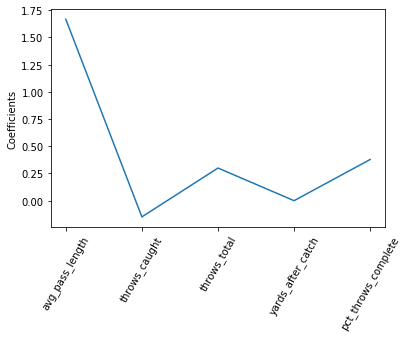

Coefficients important to determine Home Score


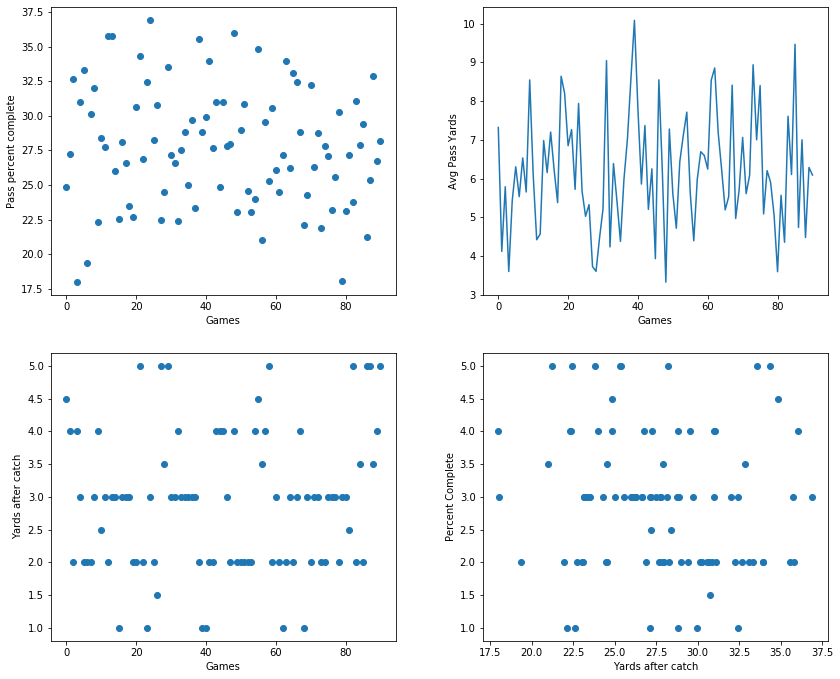

In [41]:
field_names=['avg_pass_length','throws_caught','throws_total','yards_after_catch','pct_throws_complete']
X=df[field_names].copy()
y=df['HomeScore'].copy()


lasso=Lasso(alpha=0.1)
lasso_coef=lasso.fit(X,y).coef_

_ = plt.plot(range(len(field_names)),lasso_coef)
_ = plt.xticks(range(len(field_names)),field_names,rotation=60)
_ = plt.ylabel('Coefficients')

plt.show()

print("Coefficients important to determine Home Score")

x=np.arange(len(df))
ax1 = plt.axes([0, 2, .8, 1])
ax1.plot(x,df['pct_throws_complete'],'o')
plt.ylabel('Pass percent complete')
plt.xlabel('Games')

ax2 = plt.axes([1, 2, .8, 1])
ax2.plot(x,df['avg_pass_length'])
plt.ylabel('Avg Pass Yards')
plt.xlabel('Games')

ax1 = plt.axes([0, .8, .8, 1])
ax1.plot(x,df['yards_after_catch'],'o')
plt.ylabel('Yards after catch')
plt.xlabel('Games')

ax3 = plt.axes([1, .8, .8, 1])
ax3.plot(df['pct_throws_complete'],df['yards_after_catch'],'o')

plt.ylabel('Percent Complete')
plt.xlabel('Yards after catch')
plt.show()






Graphs for a Win at Home


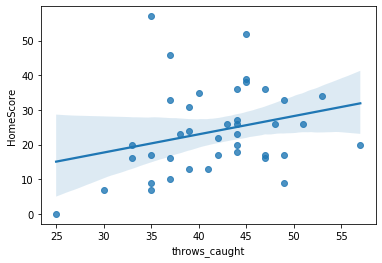

The more throws the caught the higher the Home score


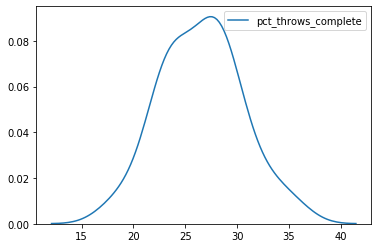

25 to 35 percent represent most of the throws caught


In [42]:
print("Graphs for a Win at Home" )

filter=df['Target']==1
sns.regplot(data=df[filter], x='throws_caught', y='HomeScore')
plt.show()
print('The more throws the caught the higher the Home score')

sns.kdeplot(df[filter]['pct_throws_complete'])
plt.show()

print("25 to 35 percent represent most of the throws caught")

Graphs for a Lose at Home


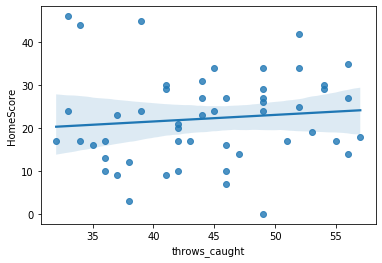

The more throws the caught the higher the Home score


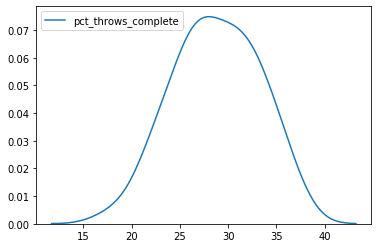

25 to 35 percent represent most of the throws caught
The home score slope is less for loss


In [43]:
print("Graphs for a Lose at Home" )
filter=df['Target']==0
sns.regplot(data=df[filter], x='throws_caught', y='HomeScore')
plt.show()
print('The more throws the caught the higher the Home score')

sns.kdeplot(df[filter]['pct_throws_complete'])
plt.show()

print("25 to 35 percent represent most of the throws caught")

print ("The home score slope is less for loss")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 3 to 16
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HomeScore            91 non-null     int32  
 1   avg_pass_length      91 non-null     float64
 2   throws_caught        91 non-null     int32  
 3   throws_total         91 non-null     int32  
 4   yards_after_catch    91 non-null     float64
 5   pct_throws_complete  91 non-null     float64
dtypes: float64(3), int32(3)
memory usage: 6.4 KB
None
       HomeScore  avg_pass_length  throws_caught  throws_total  \
count  91.000000        91.000000      91.000000     91.000000   
mean   22.945055         6.205702      43.230769    155.967033   
std    11.361106         1.495308       6.971493     12.067818   
min     0.000000         3.326531      25.000000    136.000000   
25%    16.000000         5.210149      37.500000    148.000000   
50%    23.000000         6.095238      44.00000

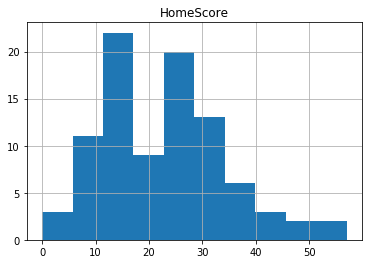

In [44]:
field_names=['HomeScore','avg_pass_length','throws_caught','throws_total','yards_after_catch','pct_throws_complete']

#print(df.head())
#dummies_segment=pd.get_dummies(df[['Team','TeamOpponent']])

#df= pd.concat([df,dummies_segment],axis=1)
#del X["Team"]
#del X["TeamOpponent"]

X=df[field_names].copy()
X['HomeScore']=X['HomeScore'].astype(int).fillna(0)
X['avg_pass_length']=X['avg_pass_length'].astype(float).fillna(0)
X['throws_caught']=X['throws_caught'].astype(int).fillna(0)
X['throws_total']=X['throws_total'].astype(int).fillna(0)
X['yards_after_catch']=X['yards_after_catch'].astype(float).fillna(0)
X['pct_throws_complete']=X['pct_throws_complete'].astype(float).fillna(0)
y=df['Target'].copy()
#print(X.head())

print(X.info())
print(X.describe())

X.hist('HomeScore')
plt.show()
#results= sm.OLS("HomeScore ~ avg_pass_length", data=X).fit()

#X_ols = sm.add_constant(X.values)
#model = sm.OLS(y, X_ols).fit()
#predictions = model.predict(X_ols) 
 
#print_model = model.summary()
#print(print_model)


#a0 = model.params['const']
#a1 = model.params['total_bill']
#a2 = model.params['time']
#a3 = model.params['size']
